# Unified Bank Statement Extraction

**Protocol**: Automatic strategy selection based on document characteristics

This notebook uses the `UnifiedBankExtractor` which automatically selects the optimal extraction strategy:

- **2-Turn Balance-Description**: When Balance column is detected (simpler, more reliable)
- **3-Turn Table Extraction**: When no Balance column exists (fallback)

---

## Workflow

```
Turn 0: Image → Header Detection (shared)
    ↓
Python: Pattern matching → Strategy selection
    ↓
Turn 1: Image → Extraction (strategy-specific)
    ↓
Python: Parsing → Filtering → Schema fields
```

## Configuration

All configs in `config/`:
- `model_config.yaml` - Model configurations (shared)
- `bank_prompts.yaml` - Bank statement extraction prompts
- `bank_column_patterns.yaml` - Column header pattern matching

In [1]:
# Cell 1: Deterministic setup and imports
# MUST be set before importing torch for deterministic CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import sys
from pathlib import Path

# Get project root (parent of bank_statement/)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Change working directory to project root
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

# Standard imports
import torch
from PIL import Image
from IPython.display import display

# Reproducibility
from common.reproducibility import set_seed, configure_deterministic_mode
set_seed(42)
configure_deterministic_mode(True)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

Working directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Random seed set to 42 for reproducibility
✅ PyTorch deterministic mode enabled
⚠️  Note: May reduce performance
PyTorch version: 2.5.1
CUDA available: True
CUDA version: 11.8


## Configuration

Select model and image path below.

In [2]:
# Cell 2: Configuration
import yaml

# ============================================================================
# SELECT MODEL - Choose from config/model_config.yaml
# ============================================================================
# InternVL3 models:
#   "internvl3_2b"      - InternVL3-2B (bfloat16, ~4GB VRAM)
#   "internvl3_8b"      - InternVL3-8B (bfloat16, L40/A10G/H200)
#   "internvl3_8b_8bit" - InternVL3-8B (8-bit quantized, V100)
#   "internvl3_5_8b"    - InternVL3.5-8B (bfloat16, H200)
#
# Llama models:
#   "llama_3_2_vision"      - Llama-3.2-Vision (bfloat16)
#   "llama_3_2_vision_8bit" - Llama-3.2-Vision (8-bit quantized)

MODEL_KEY = "llama_3_2_vision"

# ============================================================================
# SELECT IMAGE
# ============================================================================
# IMAGE_PATH = "evaluation_data/bank/minimal/image_003.png"
# IMAGE_PATH = "evaluation_data/bank/minimal/image_009.png"
# IMAGE_PATH = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_multiline.png")
IMAGE_PATH = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/cba_amount_balance.png")


# ============================================================================
# GROUND TRUTH (optional, for evaluation)
# ============================================================================
GROUND_TRUTH_PATH = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/ground_truth_bank.csv")

# ============================================================================
# Load model config
# ============================================================================
with open("config/model_config.yaml") as f:
    models_config = yaml.safe_load(f)

model_config = models_config["models"][MODEL_KEY]
loading_config = model_config.get("loading", {})
image_processing_config = model_config.get("image_processing", {})

print(f"Selected model: {model_config['name']}")
print(f"Model type: {model_config['type']}")
print(f"Model path: {model_config['default_path']}")
print(f"Quantization: {loading_config.get('quantization', 'none')}")
print(f"Torch dtype: {loading_config.get('torch_dtype', 'bfloat16')}")
print(f"Flash attention: {loading_config.get('use_flash_attn', False)}")
if image_processing_config:
    print(f"Max tiles: {image_processing_config.get('max_tiles', 14)}")
    print(f"Input size: {image_processing_config.get('input_size', 448)}")


Selected model: Llama-3.2-11B-Vision-Instruct
Model type: llama
Model path: /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct
Quantization: none
Torch dtype: bfloat16
Flash attention: False


## Load Model

Model loading is model-type specific. The cell below handles both Llama and InternVL3.

In [3]:
# Cell 3: Load model using common infrastructure
# This uses the robust model loaders with GPU-specific optimizations

MODEL_PATH = model_config["default_path"]
MODEL_TYPE = model_config["type"]
QUANTIZATION = loading_config.get("quantization", "none")
TORCH_DTYPE_STR = loading_config.get("torch_dtype", "bfloat16")
USE_FLASH_ATTN = loading_config.get("use_flash_attn", False)

print(f"Loading model: {model_config['name']}")
print(f"  Path: {MODEL_PATH}")
print(f"  Type: {MODEL_TYPE}")
print(f"  Quantization: {QUANTIZATION}")
print(f"  Dtype: {TORCH_DTYPE_STR}")
print(f"  Flash attention: {USE_FLASH_ATTN}")

if MODEL_TYPE == "llama":
    # ========================================================================
    # LLAMA MODEL LOADING
    # ========================================================================
    from common.llama_model_loader_robust import load_llama_model_robust
    
    gen_config = model_config.get("generation", {})
    
    model, processor = load_llama_model_robust(
        model_path=MODEL_PATH,
        use_quantization=(QUANTIZATION == "8bit"),
        device_map=loading_config.get("device_map", "auto"),
        max_new_tokens=gen_config.get("max_new_tokens", 4096),
        torch_dtype=TORCH_DTYPE_STR,
        low_cpu_mem_usage=loading_config.get("low_cpu_mem_usage", True),
        verbose=True
    )
    
    if loading_config.get("tie_weights", True):
        try:
            model.tie_weights()
            print("  Model weights tied")
        except Exception as e:
            print(f"  tie_weights() warning: {e}")
    
    tokenizer = None
    
    # Map dtype string to torch dtype
    DTYPE_MAP = {"bfloat16": torch.bfloat16, "float16": torch.float16, "float32": torch.float32}
    model_dtype = DTYPE_MAP.get(TORCH_DTYPE_STR, torch.bfloat16)

else:
    # ========================================================================
    # INTERNVL3 MODEL LOADING - Using common infrastructure
    # ========================================================================
    from common.internvl3_model_loader import load_internvl3_model
    
    gen_config = model_config.get("generation", {})
    
    model, tokenizer = load_internvl3_model(
        model_path=MODEL_PATH,
        use_quantization=(QUANTIZATION == "8bit"),
        device_map=loading_config.get("device_map", "auto"),
        max_new_tokens=gen_config.get("max_new_tokens", 4096),
        torch_dtype=TORCH_DTYPE_STR,
        low_cpu_mem_usage=loading_config.get("low_cpu_mem_usage", True),
        use_flash_attn=USE_FLASH_ATTN,
        verbose=True
    )
    
    processor = None
    
    # Map dtype string to torch dtype
    DTYPE_MAP = {"bfloat16": torch.bfloat16, "float16": torch.float16, "float32": torch.float32}
    model_dtype = DTYPE_MAP.get(TORCH_DTYPE_STR, torch.bfloat16)

print(f"\n✅ Model loaded successfully!")
print(f"  Final dtype: {model_dtype}")


Loading model: Llama-3.2-11B-Vision-Instruct
  Path: /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct
  Type: llama
  Quantization: none
  Dtype: bfloat16
  Flash attention: False


🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state: Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 1 GPU(s), analyzing each device...
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 1/1 GPUs detected
📊 Total Memory: 21.95GB
💾 Available Memory: 21.95GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: No
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available (0.0% used)


📊 GPU Hardware: NVIDIA L4 (1x 22GB = 22GB total)

🏗️ Architecture: cloud_inference (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (full precision: 22.0GB, threshold: 24.0GB)

💾 Available Memory: 22.0GB across 1 GPU(s)

💡 Memory sufficient: ❌ No

✅ Cloud inference GPU with 22GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 22GB

   Available Memory: 22GB

Full precision needs: 22.0GB + 2.0GB buffer = 24.0GB threshold

   Working GPUs: 1/1

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Loading processor...

✅ Model and processor loaded successfully!

📊 Single GPU Analysis:

   Device: cuda:0

   GPU: NVIDIA L4

   Memory: 19.79GB allocated, 19.91GB reserved, 24GB total

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cuda:0                        │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 4096                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 1 GPU(s)                      │ ✅ Available                      │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state: Allocated=19.79GB, Reserved=19.91GB, Fragmentation=0.12GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

  Model weights tied

✅ Model loaded successfully!
  Final dtype: torch.bfloat16


## Load Image

Loading image: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/cba_amount_balance.png
Image size: (767, 886)


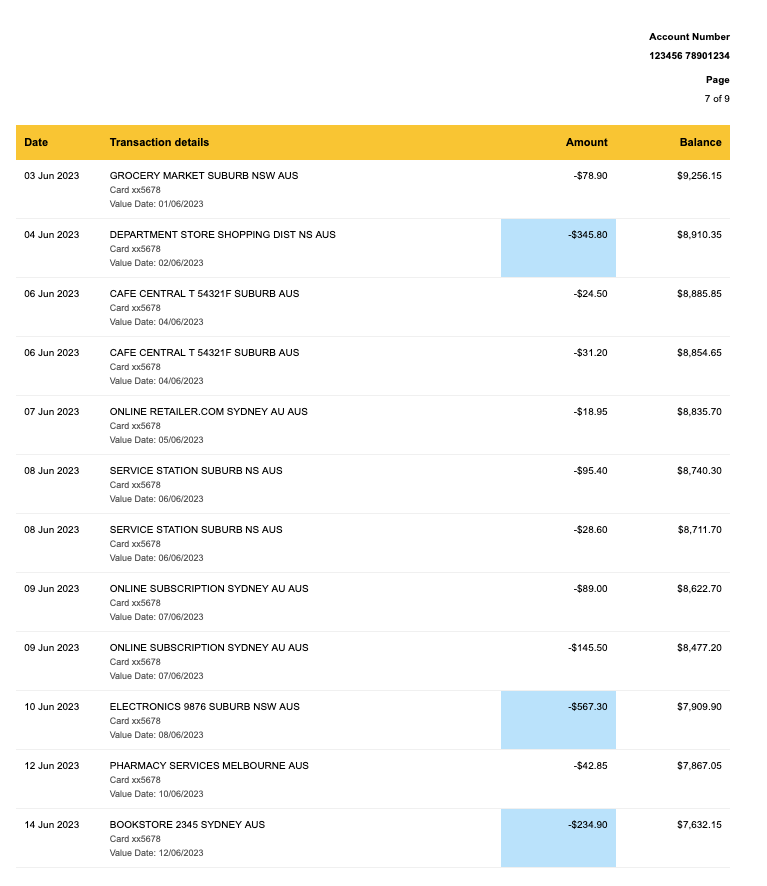

In [4]:
# Cell 4: Load image
print(f"Loading image: {IMAGE_PATH}")
image = Image.open(IMAGE_PATH).convert("RGB")
print(f"Image size: {image.size}")
display(image)

## Create Extractor and Extract

The `UnifiedBankExtractor` automatically:
1. Detects column headers (Turn 0)
2. Maps headers to semantic types
3. Selects optimal strategy based on Balance column presence
4. Executes extraction
5. Parses and filters results

In [5]:
# Cell 5: Create extractor and run extraction
from common.unified_bank_extractor import UnifiedBankExtractor

# Create extractor with image processing config from YAML
# Balance correction uses balance arithmetic to fix LLM misclassifications
extractor = UnifiedBankExtractor(
    model=model,
    tokenizer=tokenizer,
    processor=processor,
    model_type=MODEL_TYPE,
    model_dtype=model_dtype,
    image_processing_config=image_processing_config,
    use_balance_correction=True,  # ENABLED: corrects debit/credit misclassifications
)

print("="*60)
print("UNIFIED BANK STATEMENT EXTRACTION")
print("="*60)
print(f"Model type: {MODEL_TYPE}")
if MODEL_TYPE == "internvl3":
    print(f"Max tiles: {extractor.max_tiles}")
    print(f"Input size: {extractor.input_size}")
print(f"Balance correction: {'enabled' if extractor.use_balance_correction else 'disabled'}")

# Run extraction
result = extractor.extract(image)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)

UNIFIED BANK STATEMENT EXTRACTION
Model type: llama
Balance correction: enabled
Turn 0: Detecting headers...
  Detected 4 headers: ['Date', 'Transaction details', 'Amount', 'Balance']
  Balance column: Balance
  Amount column: Amount
  Debit column: NOT FOUND
  Credit column: NOT FOUND
  has_balance=True, has_amount=True, has_debit_or_credit=None
Strategy: AMOUNT_DESCRIPTION (Balance + Amount column detected (signed values))
Turn 1: Extracting transactions (amount-description)...
DEBUG: Running on GPU: NVIDIA L4
DEBUG: TURN 1 PROMPT BEING SENT
List all transactions from this bank statement, including:
- Date
- Transaction details
- Amount (preserve the sign: negative = withdrawal, positive = deposit)
- Balance

Format each entry like this:
1. **[Date]**
   - Transaction details: [ALL rows of text for this transaction]
   - Amount: [amount with sign preserved]
   - Balance: [balance amount]

CRITICAL RULES:
1. List EVERY transaction in order from top to bottom
2. EVERY entry has a date,

## View Results

In [6]:
# Cell 6: Display extraction results
print("="*60)
print("EXTRACTION METADATA")
print("="*60)
print(f"Strategy used: {result.strategy_used}")
print(f"Turns executed: {result.turns_executed}")
print(f"Headers detected: {result.headers_detected}")
if result.column_mapping:
    print(f"\nColumn mapping:")
    print(f"  Date: {result.column_mapping.date}")
    print(f"  Description: {result.column_mapping.description}")
    print(f"  Debit: {result.column_mapping.debit}")
    print(f"  Credit: {result.column_mapping.credit}")
    print(f"  Balance: {result.column_mapping.balance}")

# Display balance correction stats
if result.correction_stats:
    print(f"\nBalance correction:")
    print(f"  Total transactions: {result.correction_stats.total_transactions}")
    print(f"  Debits identified: {result.correction_stats.debits_found}")
    print(f"  Credits identified: {result.correction_stats.credits_found}")
    print(f"  Corrections made: {result.correction_stats.corrections_made}")
    if result.correction_stats.corrections_made > 0:
        print(f"    - Type swaps (debit<->credit): {result.correction_stats.type_corrections}")
    if result.correction_stats.unparseable_balances > 0:
        print(f"  Unparseable balances: {result.correction_stats.unparseable_balances}")

print("\n" + "="*60)
print("EXTRACTED SCHEMA FIELDS")
print("="*60)
schema = result.to_schema_dict()
for field, value in schema.items():
    display_value = str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
    print(f"\n{field}:")
    print(f"  {display_value}")

print("\n" + "="*60)
print("TRANSACTION SUMMARY")
print("="*60)
print(f"Total debit transactions: {len(result.transaction_dates)}")
print(f"Date range: {result.statement_date_range}")

EXTRACTION METADATA
Strategy used: amount_description_2turn
Turns executed: 2
Headers detected: ['Date', 'Transaction details', 'Amount', 'Balance']

Column mapping:
  Date: Date
  Description: Transaction details
  Debit: None
  Credit: None
  Balance: Balance

EXTRACTED SCHEMA FIELDS

DOCUMENT_TYPE:
  BANK_STATEMENT

STATEMENT_DATE_RANGE:
  03 Jun 2023 - 14 Jun 2023

TRANSACTION_DATES:
  03 Jun 2023 | 04 Jun 2023 | 06 Jun 2023 | 06 Jun 2023 | 07 Jun 2023 | 08 Jun 2023 | 08 Jun 2023 | 09...

LINE_ITEM_DESCRIPTIONS:
  NOT_FOUND

TRANSACTION_AMOUNTS_PAID:
  $78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | $89.00 | $145.50 | $567.30 | $42.85 ...

TRANSACTION SUMMARY
Total debit transactions: 12
Date range: 03 Jun 2023 - 14 Jun 2023


In [7]:
# Cell 7: Display individual transactions
print("="*60)
print("DEBIT TRANSACTIONS")
print("="*60)

for i, (date, desc, amount) in enumerate(zip(
    result.transaction_dates,
    result.line_item_descriptions,
    result.transaction_amounts_paid
), 1):
    print(f"{i}. [{date}] {desc[:50]}{'...' if len(desc) > 50 else ''} - {amount}")

DEBIT TRANSACTIONS


## Evaluation

Compare extracted results against ground truth.

In [8]:
# Cell 8: Load ground truth and evaluate
import pandas as pd
from pathlib import Path

# Import evaluation metrics
from common.evaluation_metrics import (
    calculate_field_accuracy_f1,
    load_ground_truth,
)

# Bank statement fields to evaluate
BANK_STATEMENT_FIELDS = [
    "DOCUMENT_TYPE",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "LINE_ITEM_DESCRIPTIONS",
    "TRANSACTION_AMOUNTS_PAID",
]

# Load ground truth
print("Loading ground truth...")
try:
    ground_truth_map = load_ground_truth(GROUND_TRUTH_PATH, verbose=True)
    
    # Get image filename
    image_filename = Path(IMAGE_PATH).name
    print(f"Looking up: {image_filename}")
    
    if image_filename in ground_truth_map:
        gt_data = ground_truth_map[image_filename]
        print("Ground truth found!")
        
        # Calculate F1 scores
        print("\n" + "="*90)
        print(f"FIELD COMPARISON - {image_filename}")
        print("="*90)
        
        print(f"\n{'Status':<8} {'Field':<30} {'F1':>8} {'Prec':>8} {'Recall':>8}")
        print("-"*90)
        
        total_f1 = 0.0
        field_results = {}
        
        for field in BANK_STATEMENT_FIELDS:
            extracted = schema.get(field, "NOT_FOUND")
            ground_truth = gt_data.get(field, "NOT_FOUND")
            
            if pd.isna(ground_truth):
                ground_truth = "NOT_FOUND"
            
            result_eval = calculate_field_accuracy_f1(extracted, ground_truth, field)
            f1 = result_eval.get("f1_score", 0.0)
            precision = result_eval.get("precision", 0.0)
            recall = result_eval.get("recall", 0.0)
            total_f1 += f1
            
            field_results[field] = {
                "extracted": extracted,
                "ground_truth": ground_truth,
                "f1": f1,
                "precision": precision,
                "recall": recall
            }
            
            if f1 == 1.0:
                status = "✅ OK"
            elif f1 >= 0.5:
                status = "⚠️ PART"
            else:
                status = "❌ FAIL"
            
            print(f"{status:<8} {field:<30} {f1:>7.1%} {precision:>7.1%} {recall:>7.1%}")
        
        print("-"*90)
        
        # Show detailed values (no truncation)
        print("\n📋 DETAILED VALUES:")
        print("-"*90)
        for field in BANK_STATEMENT_FIELDS:
            fr = field_results[field]
            print(f"\n{field}:")
            print(f"  Extracted:    {fr['extracted']}")
            print(f"  Ground Truth: {fr['ground_truth']}")
        
        overall_f1 = total_f1 / len(BANK_STATEMENT_FIELDS)
        print("\n" + "="*90)
        print(f"📊 OVERALL F1 SCORE: {overall_f1:.1%}")
        print("="*90)
    else:
        print(f"No ground truth found for: {image_filename}")
        
except FileNotFoundError:
    print(f"Ground truth file not found: {GROUND_TRUTH_PATH}")
    print("Skipping evaluation.")


DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
Loading ground truth...
📊 Ground truth CSV loaded with 15 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_AD

## View Raw Responses (Debug)

In [9]:
# Cell 9: View raw LLM responses (for debugging)
print("="*60)
print("RAW TURN 0 RESPONSE (Header Detection)")
print("="*60)
print(result.raw_responses.get("turn0", "N/A"))

print("\n" + "="*60)
print("RAW TURN 1 RESPONSE (Extraction)")
print("="*60)
print(result.raw_responses.get("turn1", "N/A")[:10000])
if len(result.raw_responses.get("turn1", "")) > 10000:
    print("... [truncated]")

# Debug: Show the exact prompt that was sent
print("\n" + "="*60)
print("DEBUG: TURN 1 PROMPT THAT WAS SENT")
print("="*60)
import yaml
with open("config/bank_prompts.yaml") as f:
    prompts_config = yaml.safe_load(f)
template = prompts_config["prompts"]["turn1_balance_extraction"]["template"]
actual_prompt = template.format(
    balance_col=result.column_mapping.balance,
    desc_col=result.column_mapping.description or "Description",
    debit_col=result.column_mapping.debit or "Debit",
    credit_col=result.column_mapping.credit or "Credit",
)
print(actual_prompt)
print("="*60)

RAW TURN 0 RESPONSE (Header Detection)
**Transaction Table Column Headers:**

* **Date**
* **Transaction details**
* **Amount**
* **Balance**

RAW TURN 1 RESPONSE (Extraction)
**Transaction List**

1. **03 Jun 2023**
   - GROCERY MARKET SUBURB NSW AUS
   - Card xx5678
   - Value Date: 01/06/2023
   - Amount: -$78.90
   - Balance: $9,256.15

2. **04 Jun 2023**
   - DEPARTMENT STORE SHOPPING DIST NS AUS
   - Card xx5678
   - Value Date: 02/06/2023
   - Amount: -$345.80
   - Balance: $8,910.35

3. **06 Jun 2023**
   - CAFE CENTRAL T 54321F SUBURB AUS
   - Card xx5678
   - Value Date: 04/06/2023
   - Amount: -$24.50
   - Balance: $8,885.85

4. **06 Jun 2023**
   - CAFE CENTRAL T 54321F SUBURB AUS
   - Card xx5678
   - Value Date: 04/06/2023
   - Amount: -$31.20
   - Balance: $8,854.65

5. **07 Jun 2023**
   - ONLINE RETAILER.COM SYDNEY AU AUS
   - Card xx5678
   - Value Date: 05/06/2023
   - Amount: -$18.95
   - Balance: $8,835.70

6. **08 Jun 2023**
   - SERVICE STATION SUBURB NS AUS
   -

## Summary

In [10]:
# Cell 10: Final summary
print("\n" + "="*60)
print("EXTRACTION SUMMARY")
print("="*60)
print(f"\nModel: {model_config['name']}")
print(f"Image: {IMAGE_PATH}")
print(f"Strategy: {result.strategy_used}")
print(f"Headers: {len(result.headers_detected)} detected")
print(f"Balance column: {result.column_mapping.balance if result.column_mapping else 'N/A'}")
print(f"Transactions extracted: {len(result.transaction_dates)} debits")
print(f"Date range: {result.statement_date_range}")
print(f"\nPipeline complete!")


EXTRACTION SUMMARY

Model: Llama-3.2-11B-Vision-Instruct
Image: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/cba_amount_balance.png
Strategy: amount_description_2turn
Headers: 4 detected
Balance column: Balance
Transactions extracted: 12 debits
Date range: 03 Jun 2023 - 14 Jun 2023

Pipeline complete!
